In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
import numpy as np
import math

# root dir
# data root dir
# train data root dir
# test data root dir
# val data root dir

In [ ]:
import os

ROOT_DIR = '/content'

DATA_ROOT_DIR = os.path.join(ROOT_DIR, 'Chest_Xray_Pneumonia')

TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')

TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'test')

VALIDATION_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'val')

# Google Drive 마운트해서 데이터셋 가져옴

In [ ]:
from google.colab import drive   

drive.mount('/content/gdrive/')  

Mounted at /content/gdrive/


In [ ]:
import shutil
import os

try:
    dataset_path = '/content/gdrive/My Drive/Colab Notebooks/dataset'
    
    shutil.copy(os.path.join(dataset_path, 'Chest_Xray_Pneumonia.zip'), '/content')

except Exception as err:
    print(str(err))

In [ ]:
import os
import shutil

if os.path.exists(DATA_ROOT_DIR):
    
    shutil.rmtree(DATA_ROOT_DIR)
    
    print(DATA_ROOT_DIR + ' is removed !!!')

In [ ]:
# 압축파일 풀기

# 압축파일 풀기

import zipfile

with zipfile.ZipFile(os.path.join(ROOT_DIR, 'Chest_Xray_Pneumonia.zip'), 'r') as target_file:

    target_file.extractall(DATA_ROOT_DIR) 

# Chest_Xray_Pneumonia/train 확인
# Chest_Xray_Pneumonia/test 확인
# Chest_Xray_Pneumonia/val 확인

In [ ]:
import os

#========================================================
# train 정답 및 전체 데이터 개수 확인
#========================================================

train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

print(train_label_name_list)

for label_name in train_label_name_list:

    print('train label : ', label_name,' => ', len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

print('=====================================================')

#========================================================
# test 정답 및 전체 데이터 개수 확인
#========================================================

test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)

print(test_label_name_list)

for label_name in test_label_name_list:

    print('test label : ', label_name, ' => ', len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))

print('=====================================================')

#========================================================
# validation 정답 및 전체 데이터 개수 확인
#========================================================

validation_label_name_list = os.listdir(VALIDATION_DATA_ROOT_DIR)

print(validation_label_name_list)

for label_name in validation_label_name_list:

    print('test label : ', label_name, ' => ', len(os.listdir(os.path.join(VALIDATION_DATA_ROOT_DIR, label_name))))

print('=====================================================')

['NORMAL', 'PNEUMONIA']
train label :  NORMAL  =>  1341
train label :  PNEUMONIA  =>  3875
['NORMAL', 'PNEUMONIA']
test label :  NORMAL  =>  234
test label :  PNEUMONIA  =>  390
['NORMAL', 'PNEUMONIA']
test label :  NORMAL  =>  8
test label :  PNEUMONIA  =>  8


# test 디렉토리 모든 파일을 train 동일 디렉토리로 move

In [ ]:
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)

print(test_label_name_list)

for label_name in test_label_name_list:  # Testing 디렉토리 각각의 label 에서 실행

    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)

    test_file_list = os.listdir(test_path)

    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)

    moved_num = 0

    for test_image_file in test_file_list:  # test 모든 data를 train 디렉토리로 이동

        # already exists error 방지
        # 참고소스: https://stackoverflow.com/questions/31813504
        shutil.move(os.path.join(test_path, test_image_file),
                    os.path.join(train_path, test_image_file))

        moved_num = moved_num + 1

    print(str(moved_num) + ' is moved into ' + label_name + ' (test => train)')

['NORMAL', 'PNEUMONIA']
234 is moved into NORMAL (test => train)
390 is moved into PNEUMONIA (test => train)


# val 디렉토리 모든 파일을 train 동일 디렉토리로 move

In [ ]:
validation_label_name_list = os.listdir(VALIDATION_DATA_ROOT_DIR)

print(validation_label_name_list)

for label_name in validation_label_name_list:  # val 디렉토리 각각의 label 에서 실행

    validation_path = os.path.join(VALIDATION_DATA_ROOT_DIR, label_name)

    validation_file_list = os.listdir(validation_path)

    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)

    moved_num = 0

    for validation_image_file in validation_file_list:  # val 모든 data를 train 디렉토리로 이동

        # already exists error 방지
        # 참고소스: https://stackoverflow.com/questions/31813504
        shutil.move(os.path.join(validation_path, validation_image_file),
                    os.path.join(train_path, validation_image_file))

        moved_num = moved_num + 1

    print(str(moved_num) + ' is moved into ' + label_name + ' (val => train)')

['NORMAL', 'PNEUMONIA']
8 is moved into NORMAL (val => train)
8 is moved into PNEUMONIA (val => train)


# move 비율 설정

In [ ]:
# 파일 move 비율

MOVE_RATIO = 0.2  # train : test = 80 : 20, 즉 train 데이터 20% 데이터를 test 데이터로 사용

In [ ]:
import os
import glob
import shutil
import random

# 파일 move train_data_dir => test_data_dir

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:

    # 파일 move 하기 위한 src_dir_path, dst_dir_path 설정
    #=========================================================
    src_dir_path = os.path.join(TRAIN_DATA_ROOT_DIR,label_name)  
    dst_dir_path = os.path.join(TEST_DATA_ROOT_DIR,label_name)  
    #=========================================================

    train_data_file_list = os.listdir(src_dir_path)

    print('========================================================================')
    print('total [%s] data file nums => [%s]' % (label_name ,len(train_data_file_list)))

    # data shuffle
    random.shuffle(train_data_file_list)
    print('train data shuffle is done !!!')

    split_num = int(MOVE_RATIO*len(train_data_file_list))

    print('split nums => ', split_num)

    # extract test data from train data
    test_data_file_list = train_data_file_list[0:split_num]

    move_nums = 0

    for test_data_file in test_data_file_list:

        try:
            shutil.move(os.path.join(src_dir_path, test_data_file),
                        os.path.join(dst_dir_path, test_data_file))   
        except Exception as err:
            print(str(err))

        move_nums = move_nums + 1

    print('total move nums => ', move_nums)
    print('========================================================================')

total [NORMAL] data file nums => [1583]
train data shuffle is done !!!
split nums =>  316
total move nums =>  316
total [PNEUMONIA] data file nums => [4273]
train data shuffle is done !!!
split nums =>  854
total move nums =>  854


# 정리된 데이터 최종 확인

In [ ]:
import os

#==============================================================================
# train 파일 개수 확인
#==============================================================================

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

print(label_name_list)

for label_name in label_name_list:

    label_dir = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)

    print('train label : ' + label_name + ' => ', len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

print('=====================================================')

#==============================================================================


#==============================================================================
# test 파일 개수 확인
#==============================================================================

label_name_list = os.listdir(TEST_DATA_ROOT_DIR)

print(label_name_list)

for label_name in label_name_list:

    label_dir = os.path.join(TEST_DATA_ROOT_DIR, label_name)

    print('test label : ' + label_name + ' => ', len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))

print('=====================================================')

#==============================================================================

['NORMAL', 'PNEUMONIA']
train label : NORMAL =>  1267
train label : PNEUMONIA =>  3419
['NORMAL', 'PNEUMONIA']
test label : NORMAL =>  316
test label : PNEUMONIA =>  854


# 이미지 shape 설정

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

# ImageDataGenerator 이용하여 데이터 불러옴

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255) 

test_datagen = ImageDataGenerator(rescale=1./255 )

In [ ]:
train_generator = train_datagen.flow_from_directory(TRAIN_DATA_ROOT_DIR, batch_size=16,
                                                color_mode='rgb', class_mode='sparse',
                                                target_size=(IMG_WIDTH,IMG_HEIGHT))


test_generator = test_datagen.flow_from_directory(TEST_DATA_ROOT_DIR, batch_size=16, 
                                              color_mode='rgb', class_mode='sparse',
                                              target_size=(IMG_WIDTH,IMG_HEIGHT))

Found 4686 images belonging to 2 classes.
Found 1170 images belonging to 2 classes.


In [ ]:
print(train_generator.class_indices)
print(train_generator.num_classes)

{'NORMAL': 0, 'PNEUMONIA': 1}
2


# 16 개의 데이터와 정답 가져와서 출력

In [ ]:
data, label = train_generator.next()

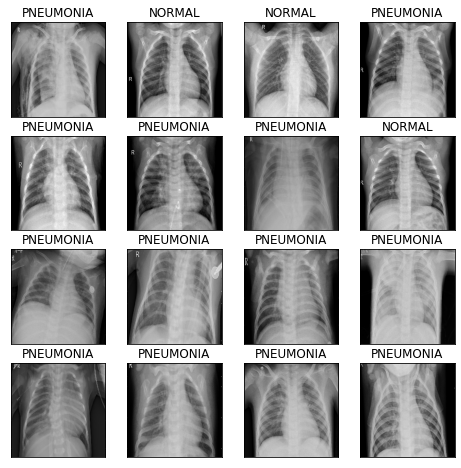

In [ ]:
import matplotlib.pyplot as plt

class_dict = {0.0: 'NORMAL', 1.0: 'PNEUMONIA'}

plt.figure(figsize=(8,8))

for i in range(len(label)):

    plt.subplot(4, 4, i+1)
    plt.title(str(class_dict[label[i]]))
    plt.xticks([]);  plt.yticks([])

    plt.imshow(data[i])

plt.show()